# Method Benchmarking

- **Creator**: Sebastian Birk (<sebastian.birk@helmholtz-munich.de>).
- **Affiliation:** Helmholtz Munich, Institute of Computational Biology (ICB), Talavera-López Lab
- **Date of Creation:** 06.01.2023
- **Date of Last Modification:** 24.02.2023

## 1. Setup

### 1.1 Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append("../../../autotalker")

In [3]:
import os
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import scanpy as sc
import scib
import seaborn as sns

from autotalker.benchmarking import compute_benchmarking_metrics
from autotalker.utils import (add_gps_from_gp_dict_to_adata,
                              extract_gp_dict_from_mebocost_es_interactions,
                              extract_gp_dict_from_nichenet_ligand_target_mx,
                              extract_gp_dict_from_omnipath_lr_interactions,
                              filter_and_combine_gp_dict_gps)

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 39086), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 39100), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/omnipath/_core/query/_query_validator.py:165: ResourceWarning: unclosed <ssl.SSLSocket fd=58, family=AddressFamily.AF_INET, type=SocketKind.SOCK_STREAM, proto=6, laddr=('10.209.62.242', 39104), raddr=('178.62.7.222', 443)>
  res = Downloader(opt).maybe_download(
/home/sbir

### 1.2 Define Parameters

In [4]:
dataset = "seqfish_mouse_organogenesis_embryo2"
cell_type_key = "celltype_mapped_refined"
spatial_key = "spatial"

In [5]:
cell_type_colors = {"Epiblast" : "#635547",
                    "Primitive Streak" : "#DABE99",
                    "Caudal epiblast" : "#9e6762",
                    "PGC" : "#FACB12",
                    "Anterior Primitive Streak" : "#c19f70",
                    "Notochord" : "#0F4A9C",
                    "Def. endoderm" : "#F397C0",
                    "Definitive endoderm" : "#F397C0",
                    "Gut" : "#EF5A9D",
                    "Gut tube" : "#EF5A9D",
                    "Nascent mesoderm" : "#C594BF",
                    "Mixed mesoderm" : "#DFCDE4",
                    "Intermediate mesoderm" : "#139992",
                    "Caudal Mesoderm" : "#3F84AA",
                    "Paraxial mesoderm" : "#8DB5CE",
                    "Somitic mesoderm" : "#005579",
                    "Pharyngeal mesoderm" : "#C9EBFB",
                    "Splanchnic mesoderm" : "#C9EBFB",
                    "Cardiomyocytes" : "#B51D8D",
                    "Allantois" : "#532C8A",
                    "ExE mesoderm" : "#8870ad",
                    "Lateral plate mesoderm" : "#8870ad",
                    "Mesenchyme" : "#cc7818",
                    "Mixed mesenchymal mesoderm" : "#cc7818",
                    "Haematoendothelial progenitors" : "#FBBE92",
                    "Endothelium" : "#ff891c",
                    "Blood progenitors 1" : "#f9decf",
                    "Blood progenitors 2" : "#c9a997",
                    "Erythroid1" : "#C72228",
                    "Erythroid2" : "#f79083",
                    "Erythroid3" : "#EF4E22",
                    "Erythroid" : "#f79083",
                    "Blood progenitors" : "#f9decf",
                    "NMP" : "#8EC792",
                    "Rostral neurectoderm" : "#65A83E",
                    "Caudal neurectoderm" : "#354E23",
                    "Neural crest" : "#C3C388",
                    "Forebrain/Midbrain/Hindbrain" : "#647a4f",
                    "Spinal cord" : "#CDE088",
                    "Surface ectoderm" : "#f7f79e",
                    "Visceral endoderm" : "#F6BFCB",
                    "ExE endoderm" : "#7F6874",
                    "ExE ectoderm" : "#989898",
                    "Parietal endoderm" : "#1A1A1A",
                    "Low quality" : "#e6e6e6",
                    "Cranial mesoderm" : "#77441B",
                    "Anterior somitic tissues" : "#F90026",
                    "Sclerotome" : "#A10037",
                    "Dermomyotome" : "#DA5921",
                    "Posterior somitic tissues" : "#E1C239",
                    "Presomitic mesoderm" : "#9DD84A",
                    "None" : "#D3D3D3"}

### 1.3 Run Notebook Setup

In [6]:
sc.set_figure_params(figsize=(6, 6))

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/scanpy/_settings.py:447: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  IPython.display.set_matplotlib_formats(*ipython_format)


In [7]:
# Get time of notebook execution for timestamping saved artifacts
now = datetime.now()
current_timestamp = now.strftime("%d%m%Y_%H%M%S")

### 1.4 Configure Paths and Directories

In [8]:
data_folder_path = "../../datasets/srt_data/gold/"
figure_folder_path = f"../../figures/{dataset}/method_benchmarking/comparison/{current_timestamp}"
gp_data_folder_path = "../../datasets/gp_data" # gene program data
nichenet_ligand_target_mx_file_path = gp_data_folder_path + "/nichenet_ligand_target_matrix.csv"
omnipath_lr_interactions_file_path = gp_data_folder_path + "/omnipath_lr_interactions.csv"

In [9]:
# Create required directories
os.makedirs(figure_folder_path, exist_ok=True)

## 2. Method Benchmarking

- Run all notebooks in the ```method_benchmarking``` directory before continuing.

### 3.1 Latent Space Comparison

#### 3.1.1 Define Function

In [10]:
def compute_latent_space_comparison(dataset,
                                    cell_type_key,
                                    n_neighbors=12,
                                    run_number=5):
    # Load data
    adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
    adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
    adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
    adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
    adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
    adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
    adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")
    
    adata_sagenet.obsm["X_umap"] = adata_sagenet.obsm[f"sagenet_latent_run{run_number}"] # latent representation of SageNet are already UMAP features
    for adata, method in zip([adata_pca, adata_scvi, adata_expimap, adata_deeplinc, adata_graphst, adata_autotalker],
                             ["pca", "scvi", "expimap", "deeplinc", "graphst", "autotalker"]):
        sc.pp.neighbors(adata,
                        use_rep=f"{method}_latent_run{run_number}",
                        n_neighbors=n_neighbors)
        sc.tl.umap(adata)
        
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))
    plt.suptitle("Latent Space Comparison", fontsize=25, x=0.575)
    plt.subplots_adjust(hspace=0.25, wspace=0.25, top=0.9)
    axs=axs.flatten()

    sc.pl.spatial(adata=adata,
                  color=[cell_type_key],
                  palette=cell_type_colors,
                  spot_size=0.03,
                  ax=axs[0],
                  show=False)
    axs[0].set_title("Physical Space", fontsize=17)
    handles, labels = axs[0].get_legend_handles_labels()
    lgd = fig.legend(handles, labels, loc="upper center", bbox_to_anchor=(1.07, 0.845))
    axs[0].get_legend().remove()

    for i, (adata, title) in enumerate(zip([adata_autotalker, adata_deeplinc, adata_graphst, adata_sagenet, adata_pca, adata_scvi, adata_expimap],
                                           ["Autotalker", "DeepLinc", "GraphST", "SageNet", "Log Normalized Counts PCA", "scVI", "expiMap"])):        
        sc.pl.umap(adata,
                   color=[cell_type_key],
                   palette=cell_type_colors,
                   ax=axs[i + 1],
                   show=False,
                   legend_loc=None)
        axs[i + 1].set_title(title, fontsize=17)

    fig.savefig(f"{figure_folder_path}/latent_comparison.png",
                bbox_inches="tight")
    plt.show()

#### 3.1.2 Run Function

In [ ]:
compute_latent_space_comparison(dataset="seqfish_mouse_organogenesis_embryo2",
                                cell_type_key="celltype_mapped_refined",
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="vizgen_merfish_mouse_liver",
                                cell_type_key="Cell_Type",
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="starmap_plus_mouse_cns",
                                cell_type_key="Main_molecular_cell_type",
                                n_neighbors=12,
                                run_number=5)

In [ ]:
compute_latent_space_comparison(dataset="nanostring_cosmx_human_nsclc",
                                cell_type_key="cell_type",
                                n_neighbors=12,
                                run_number=5)

### 3.2 Benchmarking Metrics

#### 3.2.1 Define Functions

In [11]:
def compute_combined_benchmarking_metrics(model_adata,
                                          model_name,
                                          cell_type_key,
                                          run_number_list=list(np.arange(1, 11)),
                                          n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                          ger_genes=None):
    benchmarking_dict_list = []
    for run_number, n_neighbors in zip(run_number_list, n_neighbors_list):
        
        # Compute Autotalker metrics
        benchmarking_dict = compute_benchmarking_metrics(adata=model_adata,
                                                         latent_key=f"{model_name}_latent_run{run_number}",
                                                         cell_type_key=cell_type_key,
                                                         spatial_key=spatial_key,
                                                         spatial_knng_key=f"spatial_{n_neighbors}nng",
                                                         latent_knng_key=f"{model_name}_latent_{n_neighbors}nng_run{run_number}",
                                                         ger_genes=ger_genes)
        benchmarking_dict["model_name"] = model_name
        benchmarking_dict["run"] = run_number
        benchmarking_dict_list.append(benchmarking_dict)
    return benchmarking_dict_list

In [12]:
def compute_combined_benchmarking_metrics_for_all_models(dataset,
                                                         cell_type_key,
                                                         run_number_list=list(np.arange(1, 11)),
                                                         n_neighbors_list=[4, 4, 8, 8, 12, 12, 16, 16, 20, 20],
                                                         use_only_gp_mask_target_genes_for_gene_expr_regr=True):
    # Configure dataset artifact folder path
    dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/{current_timestamp}"
    os.makedirs(dataset_artifact_folder_path, exist_ok=True)
    
    if use_only_gp_mask_target_genes_for_gene_expr_regr:
        # Identify genes that are available in gp mask as target genes
        print("Retrieving gp mask target genes...")
        adata = sc.read_h5ad(data_folder_path + f"{dataset}.h5ad")
        
        nichenet_gp_dict = extract_gp_dict_from_nichenet_ligand_target_mx(
            keep_target_ratio=0.01,
            load_from_disk=False,
            save_to_disk=False,
            file_path=nichenet_ligand_target_mx_file_path)

        omnipath_gp_dict = extract_gp_dict_from_omnipath_lr_interactions(
            min_curation_effort=0,
            load_from_disk=False,
            save_to_disk=False,
            file_path=omnipath_lr_interactions_file_path)

        mebocost_gp_dict = extract_gp_dict_from_mebocost_es_interactions(
            dir_path=f"{gp_data_folder_path}/metabolite_enzyme_sensor_gps/",
            species="mouse",
            genes_uppercase=True)

        # Combine gene programs into one dictionary
        combined_gp_dict = dict(nichenet_gp_dict)
        combined_gp_dict.update(omnipath_gp_dict)
        combined_gp_dict.update(mebocost_gp_dict)

        # Filter and combine gene programs
        combined_new_gp_dict = filter_and_combine_gp_dict_gps(
            gp_dict=combined_gp_dict,
            gp_filter_mode="subset", #None,
            combine_overlap_gps=True, #True,
            overlap_thresh_source_genes=0.9,
            overlap_thresh_target_genes=0.9,
            overlap_thresh_genes=0.9,
            verbose=True)

        # Add the gene program dictionary as binary masks to the adata for model training
        add_gps_from_gp_dict_to_adata(
            gp_dict=combined_new_gp_dict,
            adata=adata,
            genes_uppercase=True,
            gp_targets_mask_key="autotalker_gp_targets",
            gp_sources_mask_key="autotalker_gp_sources",
            gp_names_key="autotalker_gp_names",
            min_genes_per_gp=1,
            min_source_genes_per_gp=0,
            min_target_genes_per_gp=0,
            max_genes_per_gp=None,
            max_source_genes_per_gp=None,
            max_target_genes_per_gp=None)

        ger_genes = adata.var_names[adata.uns["autotalker_target_genes_idx"]].tolist()
        del(adata)
    else:
        ger_genes = None
        
    # PCA
    print("Computing metrics for PCA...")
    adata_pca = sc.read_h5ad(data_folder_path + f"{dataset}_pca.h5ad")
    benchmarking_dict_list_pca = compute_combined_benchmarking_metrics(model_adata=adata_pca,
                                                                       model_name="pca",
                                                                       run_number_list=run_number_list,
                                                                       n_neighbors_list=n_neighbors_list,
                                                                       cell_type_key=cell_type_key,
                                                                       ger_genes=ger_genes)   
    
    benchmarking_dict_list = benchmarking_dict_list_pca
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_pca)
    print("")
    
    # scVI
    print("Computing metrics for scVI...")
    adata_scvi = sc.read_h5ad(data_folder_path + f"{dataset}_scvi.h5ad")
    benchmarking_dict_list_scvi = compute_combined_benchmarking_metrics(model_adata=adata_scvi,
                                                                        model_name="scvi",
                                                                        run_number_list=run_number_list,
                                                                        n_neighbors_list=n_neighbors_list,
                                                                        cell_type_key=cell_type_key,
                                                                        ger_genes=ger_genes)  
    benchmarking_dict_list += benchmarking_dict_list_scvi
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_scvi)
    print("")
    
    # expiMap
    print("Computing metrics for expiMap...")
    adata_expimap = sc.read_h5ad(data_folder_path + f"{dataset}_expimap.h5ad")
    benchmarking_dict_list_expimap = compute_combined_benchmarking_metrics(model_adata=adata_expimap,
                                                                           model_name="expimap",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key,
                                                                           ger_genes=ger_genes)  
    benchmarking_dict_list += benchmarking_dict_list_expimap
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_expimap)
    print("")
    
    # SageNet
    print("Computing metrics for SageNet...")
    adata_sagenet = sc.read_h5ad(data_folder_path + f"{dataset}_sagenet.h5ad")
    benchmarking_dict_list_sagenet = compute_combined_benchmarking_metrics(model_adata=adata_sagenet,
                                                                           model_name="sagenet",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key,
                                                                           ger_genes=ger_genes) 
    benchmarking_dict_list += benchmarking_dict_list_sagenet
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_sagenet)
    print("")
    
    # DeepLinc
    print("Computing metrics for DeepLinc...")
    adata_deeplinc = sc.read_h5ad(data_folder_path + f"{dataset}_deeplinc.h5ad")
    benchmarking_dict_list_deeplinc = compute_combined_benchmarking_metrics(model_adata=adata_deeplinc,
                                                                            model_name="deeplinc",
                                                                            run_number_list=run_number_list,
                                                                            n_neighbors_list=n_neighbors_list,
                                                                            cell_type_key=cell_type_key,
                                                                            ger_genes=ger_genes)
    benchmarking_dict_list += benchmarking_dict_list_deeplinc
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_deeplinc)
    print("")
    
    # GraphST
    print("Computing metrics for GraphST...")
    adata_graphst = sc.read_h5ad(data_folder_path + f"{dataset}_graphst.h5ad")
    benchmarking_dict_list_graphst = compute_combined_benchmarking_metrics(model_adata=adata_graphst,
                                                                           model_name="graphst",
                                                                           run_number_list=run_number_list,
                                                                           n_neighbors_list=n_neighbors_list,
                                                                           cell_type_key=cell_type_key,
                                                                           ger_genes=ger_genes)
    benchmarking_dict_list += benchmarking_dict_list_graphst
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_graphst)
    print("")
    
    # Autotalker
    print("Computing metrics for Autotalker...")
    adata_autotalker = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")
    benchmarking_dict_list_autotalker = compute_combined_benchmarking_metrics(model_adata=adata_autotalker,
                                                                              model_name="autotalker",
                                                                              run_number_list=run_number_list,
                                                                              n_neighbors_list=n_neighbors_list,
                                                                              cell_type_key=cell_type_key,
                                                                              ger_genes=ger_genes)
    benchmarking_dict_list += benchmarking_dict_list_autotalker
    with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "wb") as f:
        pickle.dump(benchmarking_dict_list, f)
    del(adata_autotalker)
    print("")

In [13]:
def create_summary_plot(dataset):
    # Read complete benchmarking data from disk
    with open(f"{artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
        benchmarking_dict_list = pickle.load(f)
        
    df = pd.DataFrame(benchmarking_dict_list)

#### 3.2.2 Run Functions

In [101]:
compute_combined_benchmarking_metrics_for_all_models(dataset="seqfish_mouse_organogenesis_embryo2",
                                                     cell_type_key="celltype_mapped_refined")

Retrieving gp mask target genes...
Removing GP 'CTF1_ligand_receptor_GP' as it is a subset of GP 'CTF1_ligand_targetgenes_GP'.
Removing GP 'LEP_ligand_receptor_GP' as it is a subset of GP 'LEP_ligand_targetgenes_GP'.
Removing GP 'IL4_ligand_receptor_GP' as it is a subset of GP 'IL4_ligand_targetgenes_GP'.
Removing GP 'IL12A_ligand_receptor_GP' as it is a subset of GP 'IL12A_ligand_targetgenes_GP'.
Removing GP 'IL23A_ligand_receptor_GP' as it is a subset of GP 'IL23A_ligand_targetgenes_GP'.
Removing GP 'CSF2_ligand_receptor_GP' as it is a subset of GP 'CSF2_ligand_targetgenes_GP'.
Removing GP 'IL21_ligand_receptor_GP' as it is a subset of GP 'IL21_ligand_targetgenes_GP'.
Removing GP 'TSLP_ligand_receptor_GP' as it is a subset of GP 'TSLP_ligand_targetgenes_GP'.
Removing GP 'GH2_ligand_receptor_GP' as it is a subset of GP 'GH2_ligand_targetgenes_GP'.
Removing GP 'EGF_ligand_receptor_GP' as it is a subset of GP 'EGF_ligand_targetgenes_GP'.
Removing GP 'IL10_ligand_receptor_GP' as it is a 

/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.5475538177342
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.4906321731881
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.9505855385374
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.9322549607962
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.78650362569215
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.98117119571316
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.43740160725156
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.56486581714444
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


493.47359348512856
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


492.8620702624962
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for scVI...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


488.91366105059507
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


500.5947935867778
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


490.06078176516667
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


489.7943470415343
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


507.3092255048466
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


499.7134318974363
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


494.1156023922665
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


484.09862883334995
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


501.3806408164547
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


500.41878044173285
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for expiMap...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


546.9360860790147
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


522.9445021055642
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


521.1489450362113
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


543.7711611892092
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


542.0065082958512
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


517.4456526786613
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


525.2632343595603
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


514.0090964761208
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


519.4873436439317
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


515.2549877010646
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for SageNet...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


247.22893586835
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


240.25244600163893
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


267.8886774790326
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


258.8726807780733
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


316.5952478166367
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


319.75418354850143
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


321.332733470084
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


313.4891223645581
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


334.7285056398724
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


333.72706854629945
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for DeepLinc...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


263.6069117085311
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


209.27507167077962
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


176.83853667653347
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


147.05476446417794
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


130.96333743497206
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


124.40205129076449
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


129.86366652490392
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


130.28105884436096
Computing CLISIS...
Computing GERR2...
Computing CCA...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/sklearn/neural_network/_multilayer_perceptron.py:684: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


109.81416480393982
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


137.52698305769928
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for GraphST...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


244.42334232221546
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


229.58915468067764
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


190.2965194334056
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


196.47993303070876
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


188.16025925048024
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


183.95024057896822
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


180.18798071434728
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


187.0276580956421
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


190.78583004118568
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


192.11659452770434
Computing CLISIS...
Computing GERR2...
Computing CCA...

Computing metrics for Autotalker...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


196.93298416494008
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


201.5065468476908
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


138.57367601767274
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


139.075122997808
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


89.83939657654017
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


82.05569825474018
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


64.54054077279652
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


58.76824439407831
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


52.390119894899826
Computing CLISIS...
Computing GERR2...
Computing CCA...
Computing GCS...
Computing MLAMI...
Computing CAS...


/home/sbirk/miniconda3/envs/autotalker/lib/python3.9/site-packages/squidpy/gr/_nhood.py:182: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


61.19779120825672
Computing CLISIS...
Computing GERR2...
Computing CCA...



In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="vizgen_merfish_mouse_liver",
                                                     cell_type_key="Cell_Type",)

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="starmap_plus_mouse_cns",
                                                     cell_type_key="Main_molecular_cell_type")

In [ ]:
compute_combined_benchmarking_metrics_for_all_models(dataset="nanostring_cosmx_human_nsclc",
                                                     cell_type_key="cell_type")

#### 3.2.8 Summary

In [102]:
dataset_artifact_folder_path = f"../../artifacts/{dataset}/method_benchmarking/comparison/24022023_115320"

In [103]:
# Read complete benchmarking data from disk
with open(f"{dataset_artifact_folder_path}/benchmarking_dict_list.pickle", "rb") as f:
    benchmarking_dict_list = pickle.load(f)

In [104]:
df = pd.DataFrame(benchmarking_dict_list)
df.head()

,gcs,mlami,cas,clisis,gerr2,cca,model_name,run
0,0.785326,0.595748,0.521462,0.915496,0.310614,0.94466,pca,1
1,0.785325,0.593315,0.522143,0.914990,0.310614,0.94466,pca,2
2,0.785339,0.596942,0.521847,0.914751,0.310614,0.94466,pca,3
3,0.785333,0.596263,0.521858,0.914524,0.310614,0.94466,pca,4
4,0.785354,0.596801,0.521309,0.914634,0.310614,0.94466,pca,5


In [105]:
# Compute metric means over all runs
mean_df = df.groupby("model_name").mean()

columns = ["gcs",
           "mlami",
           "cas",
           "clisis",
           "gerr2",
           "cca"]

rows = ["autotalker",
        "deeplinc",
        "graphst",
        "sagenet",
        "pca",
        "scvi",
        "expimap"]

mean_df = mean_df[columns]
mean_df = mean_df.reindex(rows)

mean_df

,gcs,mlami,cas,clisis,gerr2,cca
model_name,,,,,,
autotalker,0.964234,0.838604,0.872281,0.951468,0.233054,0.840381
deeplinc,0.883191,0.776112,0.818393,0.948148,0.179197,0.824660
graphst,0.933714,0.793992,0.771552,0.944306,0.251373,0.859351
sagenet,0.771935,0.691595,0.676206,0.908252,0.039093,0.576038
pca,0.785335,0.595125,0.521749,0.914993,0.310614,0.944660
scvi,0.791572,0.615918,0.520148,0.919051,0.148858,0.904892
expimap,0.762724,0.413443,0.500788,0.891653,0.220330,0.929581


In [33]:
import scipy.sparse as sp

dense_matrix = np.array([[1, 1, 0, 1], [1, 1, 0, 1], [1, 1, 0, 1], [1, 1, 0, 1]])
dense_matrix2 = np.array([[1, 0, 1, 1], [1, 0, 1, 1], [1, 0, 1, 1], [1, 0, 1, 1]])

# Convert the dense matrix to a sparse CSR matrix
sparse_matrix = sp.csr_matrix(dense_matrix)
sparse_matrix2 = sp.csr_matrix(dense_matrix2)

dif = sparse_matrix - sparse_matrix2

In [34]:
    gcd = sp.linalg.norm(dif,
                         ord="fro")

In [67]:
from autotalker.benchmarking import compute_cas

In [73]:
adata = sc.read_h5ad(data_folder_path + f"{dataset}_autotalker.h5ad")

In [96]:
    cas = compute_cas(
        adata=adata,
        cell_type_key="celltype_mapped_refined",
        spatial_knng_key="autotalker_spatial_knng_key",
        latent_knng_key="autotalker_latent_knng_key",
        latent_key="autotalker_latent_run1",
        seed=0)

196.93298416494008


In [92]:
np.log2(90)

6.491853096329675

##### 3.2.8.1 Metrics Plot

In [21]:
plt.figure(figsize=(15,15))
ax = sns.barplot(data=mean_df
                 x='score',
                 y='score_type',
                 hue='model',
                 palette='Paired',
                 orient='h')

plt.xticks(fontsize=40)
plt.yticks(fontsize=40)


plt.xlabel('Metric value (lower better)', fontsize=40)
plt.ylabel('Metric type', fontsize=40)
plt.legend(loc=2, bbox_to_anchor=(1, 1), prop={'size': 28})
plt.title('Evaluation metrics predictions on BBBC021', fontsize=40)
#plt.savefig('/lustre/groups/ml01/workspace/alessandro.palma/imCPA_official/experiments/general_experiments/1.benchmark_scores/plots/benchmark_scores_final.svg',
#           dpi=300, bbox_inches='tight', format='svg')
plt.show()

SyntaxError: invalid syntax (452379698.py, line 3)

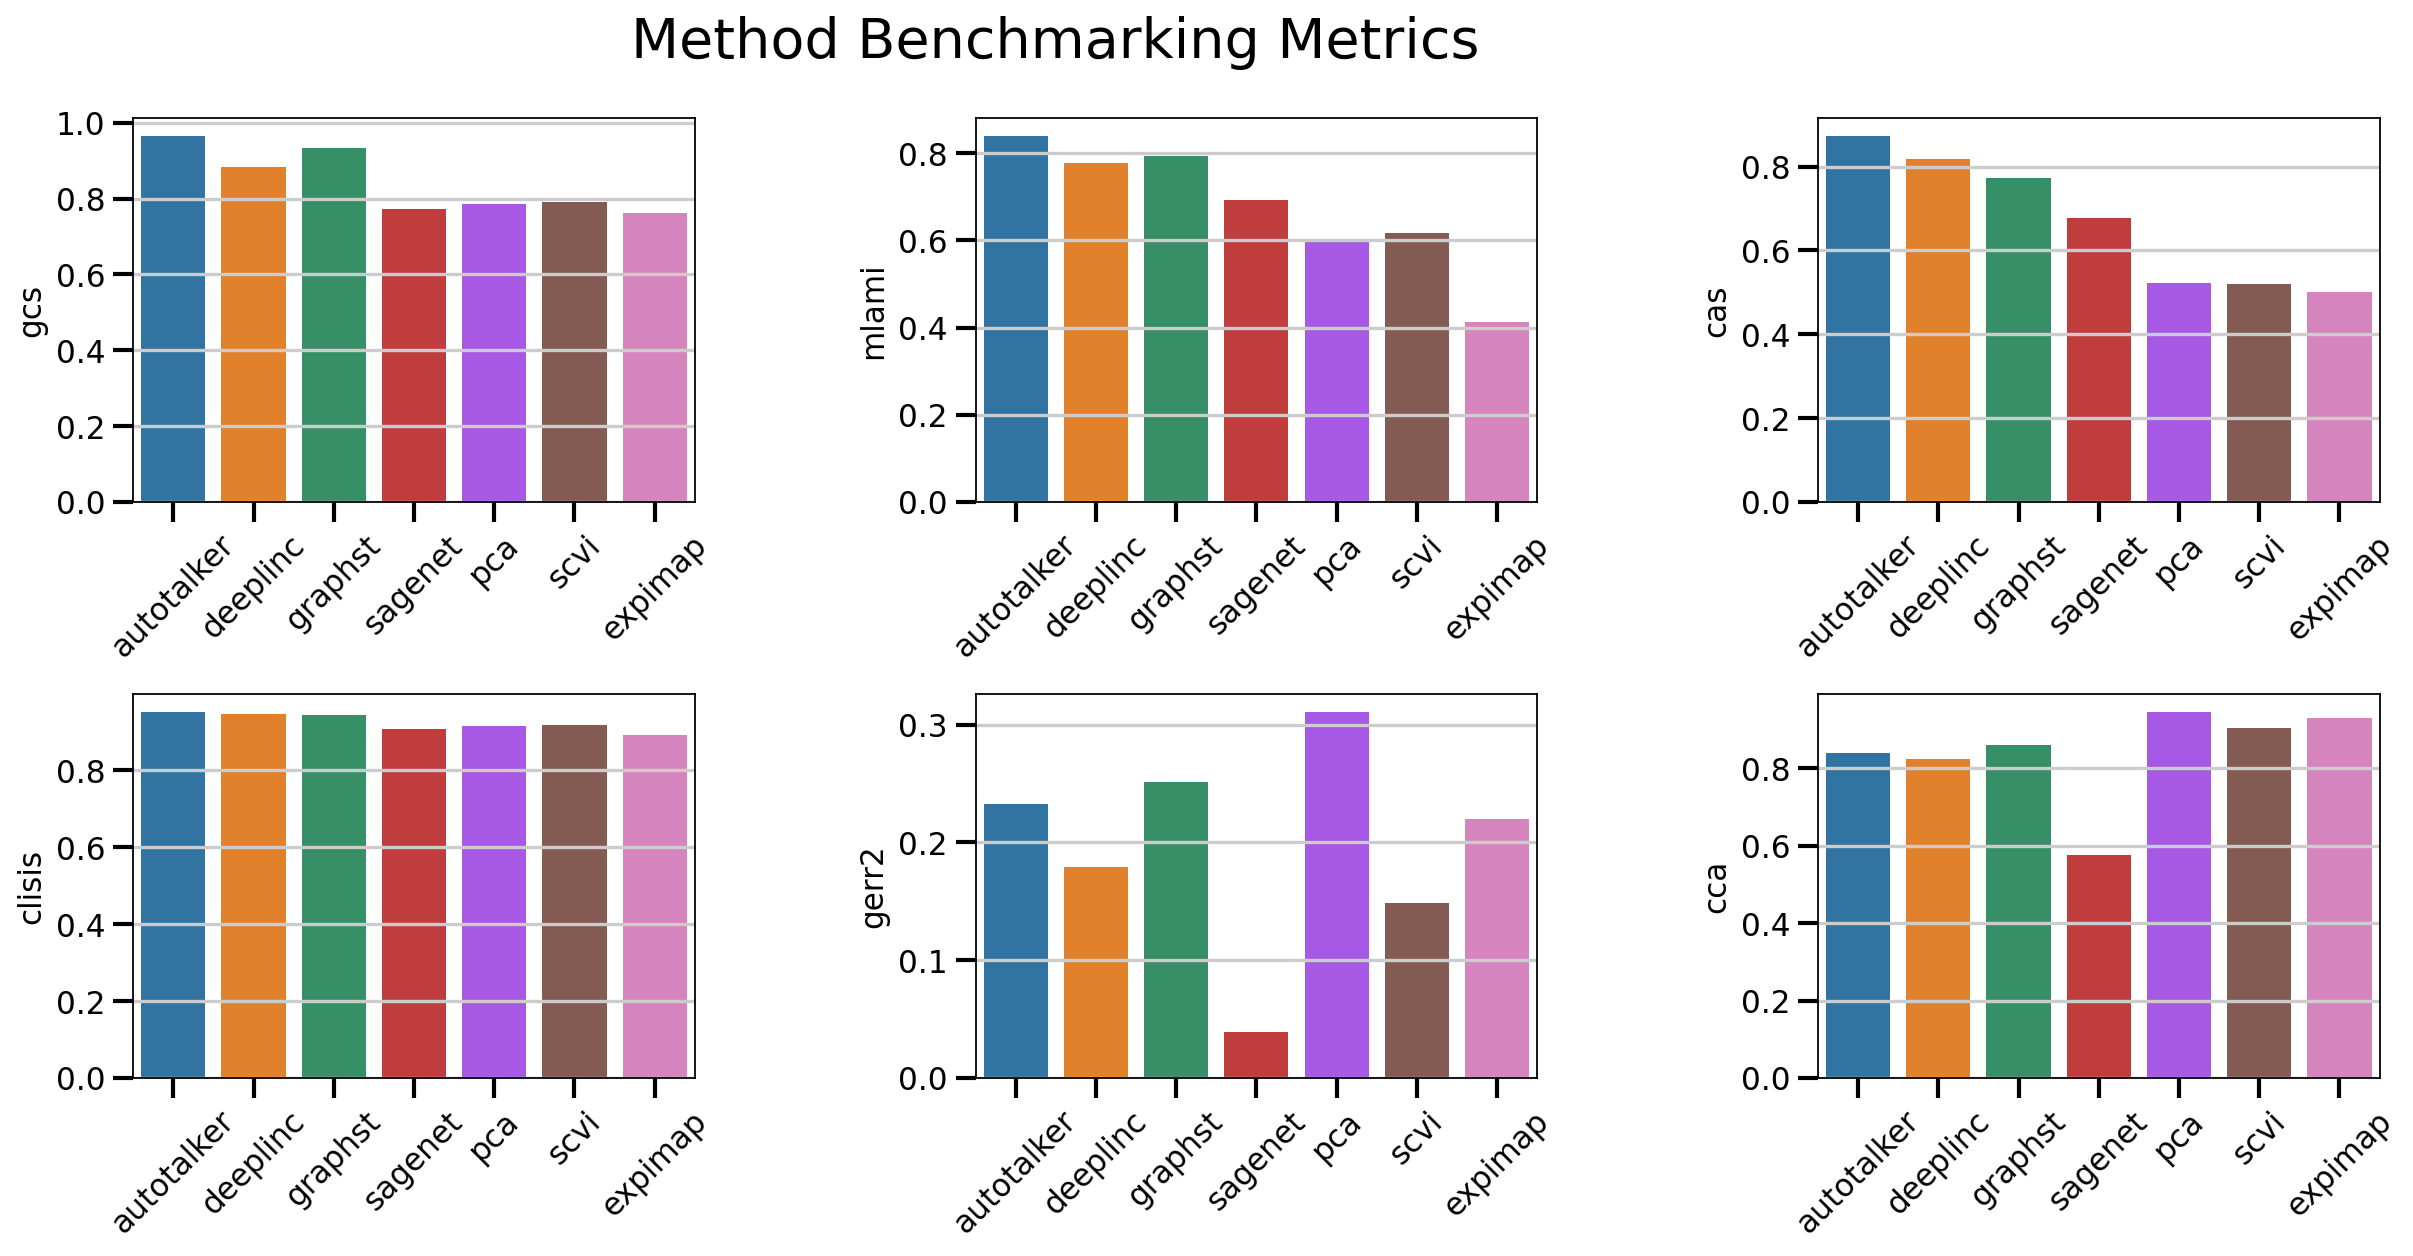

In [106]:
fig, axs = plt.subplots(nrows=2, ncols=int(np.ceil(len(columns)/2)), figsize=(3*len(columns), 8))
axs=axs.flatten()

for i, col in enumerate(columns):
    sns.barplot(data=mean_df, x=mean_df.index, y=col, ax=axs[i])
    axs[i].set_xlabel('')
    xlabels = axs[i].get_xticks()
    axs[i].set_xticklabels(mean_df.index, rotation=45)
plt.suptitle("Method Benchmarking Metrics", fontsize=25)
plt.subplots_adjust(hspace=0.5, wspace=0.5, top=0.9)

if len(columns) % 2 != 0:
    fig.delaxes(axs[-1])

fig.savefig(f"{figure_folder_path}/metrics_{current_timestamp}.png",
            bbox_inches="tight")    
plt.show()

##### 3.2.8.1 Metrics Ranking Plot

In [ ]:
mean_df_min_best = mean_df[["gcd", "cad", "arclisi", "germse"]] # lower values are better
mean_df_max_best = mean_df[["mlnmi", "cca", "ari", "clisi", "nmi", "asw", "ilasw", ]] # higher values are better
rank_df_min = mean_df_min_best.rank(method="max", ascending=True)
rank_df_max = mean_df_max_best.rank(method="max", ascending=False)
rank_df = pd.concat([rank_df_min, rank_df_max], axis=1)
rank_df = rank_df[columns]

In [ ]:
heatmap = sns.heatmap(rank_df, annot=True, cmap="YlGnBu")
fig = heatmap.get_figure()
plt.title("Method Benchmarking Metrics Ranking", fontsize=20, pad=25)
plt.xticks(rotation=45)
fig.savefig(f"{figure_folder_path}/metrics_ranking_{current_timestamp}.png",
            bbox_inches="tight")
plt.show()